In [1]:
import numpy as np
import pandas as pd

Data = pd.read_csv('CS598PS_Project_master/friends/labels',sep='\t',header=None)
data = Data.iloc[0:135]
#labels1 = np.array(labels.iloc[1::2,0])
#labels1 = np.hstack([labels.iloc[0,0],labels1])
#print(labels1.shape)
#labels2 = pd.get_dummies(labels.iloc[::2,1])
#labels2 = np.array(labels2)
#print(labels1.shape)
#labels = np.zeros((135,9))
#labels[:,0] = labels1
#labels[:,1:9] = labels2
labels = pd.DataFrame(np.zeros((607,1)))
for i in range(135):
    first = int(data.iloc[i,2])
    second = int(data.iloc[i,3])
    for j in range(first,second+1):
        labels.iloc[j,0]=data.iloc[i,1]
for i in range(607):
    if labels.iloc[i,0] == 'R':
        labels.iloc[i,0] = 1
    #if labels.iloc[i,0] == 'C':
     #   labels.iloc[i,0] = 2
    elif labels.iloc[i,0] == 'M':
        labels.iloc[i,0] = 2
    elif labels.iloc[i,0] == 'J':
        labels.iloc[i,0] = 3
    elif labels.iloc[i,0] == 'S':
        labels.iloc[i,0] = 4
    else:
        labels.iloc[i,0] = 0
    #if labels.iloc[i,0] == 'P':
    #    labels.iloc[i,0] = 6
    #if labels.iloc[i,0] == 'X':
    #    labels.iloc[i,0] = 7
    #if labels.iloc[i,0] == 'Z':
    #    labels.iloc[i,0] = 8
Labels = pd.get_dummies(labels)
print(labels.shape)

(607, 1)


In [2]:
from scipy.io.wavfile import read as wavread
from scipy.signal import stft
import numpy as np
import matplotlib.pyplot as plt
from librosa.feature import mfcc
import librosa.display
from scipy import signal

# Load the file and convert to floating point
import scipy.io.wavfile
fs,s = scipy.io.wavfile.read('FriendsS09E01.wav')
s = s.astype( float)
print(s.shape,fs)
plt.subplot( 2, 1, 1), plt.plot( np.arange( 0, len( s))/fs, s)
plt.title( 'Input sound'), plt.xlabel( 'Time (sec)')
plt.title('Input wave')
plt.show()
# Get the magnitude spectrogram
f, t, S = signal.stft(s,window=signal.get_window('hann',1024),noverlap=768,nperseg = 1024)
partition = len(s)/fs
slide = int(S.shape[1]//partition+1)
k = 0
data_slide = []
print(partition,slide)
while k < partition:
    left = k*slide
    right = min(S.shape[1]+1,(k+1)*slide)
    par = S[:,left:right]
    data_slide.append(par)
    k += 1
print(len(data_slide),data_slide[0].shape)

(71989248,) 48000


<Figure size 640x480 with 1 Axes>

1499.776 188
1500 (513, 188)


(71989248,) 48000


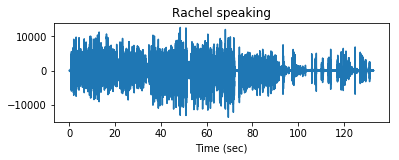

In [3]:
fs,s_r = scipy.io.wavfile.read('R-Final-48k.wav')
s_r = s_r.astype( float)
print(s.shape,fs)
plt.subplot( 2, 1, 1), plt.plot(np.arange( 0, len(s_r))/fs, s_r)
plt.title( 'Input sound'), plt.xlabel( 'Time (sec)')
plt.title('Rachel speaking')
plt.show()

(71989248,) 48000


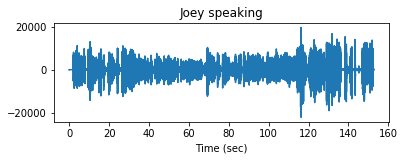

In [4]:
fs,s_j = scipy.io.wavfile.read('J-Final-48k.wav')
s_j = s_j.astype( float)
print(s.shape,fs)
plt.subplot(2, 1, 1), plt.plot(np.arange( 0, len(s_j))/fs, s_j)
plt.title( 'Input sound'), plt.xlabel( 'Time (sec)')
plt.title('Joey speaking')
plt.show()

(71989248,) 48000


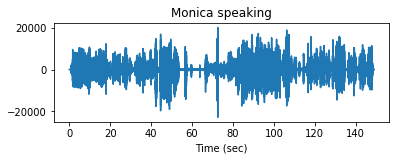

In [5]:
fs,s_m = scipy.io.wavfile.read('M-Final-48k.wav')
s_m = s_m.astype( float)
print(s.shape,fs)
plt.subplot( 2, 1, 1), plt.plot(np.arange( 0, len(s_m))/fs, s_m)
plt.title( 'Input sound'), plt.xlabel( 'Time (sec)')
plt.title('Monica speaking')
plt.show()

(71989248,) 48000


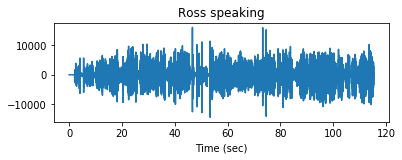

In [6]:
fs,s_s = scipy.io.wavfile.read('S-Final-48k.wav')
s_s = s_s.astype( float)
print(s.shape,fs)
plt.subplot( 2, 1, 1), plt.plot(np.arange( 0, len(s_s))/fs, s_s)
plt.title( 'Input sound'), plt.xlabel( 'Time (sec)')
plt.title('Ross speaking')
plt.show()

In [7]:
train = np.asarray(data_slide[0:607])
test = np.asarray(data_slide[607:-6])
f.shape,t.shape,s.shape,fs,len(s)/fs,S.shape,train.shape,Labels.shape,labels.shape,test.shape

((513,),
 (281209,),
 (71989248,),
 48000,
 1499.776,
 (513, 281209),
 (607, 513, 188),
 (607, 1),
 (607, 1),
 (887, 513, 188))

In [8]:
# Take as SVM with stacking
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

train_linear = np.zeros((607*188,513))
label_linear = np.zeros((607*188,1))
Label_linear = np.zeros((607*188,1))
for i in range(train.shape[0]):
    for j in range(train.shape[2]):
        train_linear[i*188:(i+1)*188,:] = train[i,:,j]
    label_linear[i*188:(i+1)*188,0] = np.repeat(labels.iloc[i,0],188).astype(int)
    Label_linear[i*188:(i+1)*188,0] = np.repeat(Labels.iloc[i,0],188).astype(int)
print(train_linear.shape,label_linear.shape)
#clf = SVC(gamma='auto')
#clf.fit(train_linear, label_linear.ravel())
#clf.get_params()
print('completed')

/Users/xiujiayang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  # Remove the CWD from sys.path while we load stuff.


(114116, 513) (114116, 1)
completed


In [9]:
# Use sample to generate classifier
def get_train(file):
    fs,s = scipy.io.wavfile.read(file)
    s = s.astype(float)
    print(s.shape)
    f, t, S = signal.stft(s,window=signal.get_window('hann',1024),noverlap=768,nperseg = 1024)
    partition = len(s)/fs
    slide = int(S.shape[1]//partition+1)
    k = 0
    data_slide = []
    while k < partition:
        left = k*slide
        right = min(S.shape[1]+1,(k+1)*slide)
        par = S[:,left:right]
        data_slide.append(par)
        k += 1
    i = 1
    while data_slide[-i].shape[1] != 188:
        i += 1
    return data_slide[:-(i+1)]
train_j = get_train('J-Final-48k.wav')
train_m = get_train('M-Final-48k.wav')
train_r = get_train('R-Final-48k.wav')
train_s = get_train('S-Final-48k.wav')
labels_j = np.ones((len(train_j),1))*3
labels_m = np.ones((len(train_m),1))*2
labels_r = np.ones((len(train_r),1))
labels_s = np.ones((len(train_s),1))*4
labels_others = np.zeros((100,1))
train_data = train_j+train_m+train_r+train_s+data_slide[0:100]
train_data = np.asarray(train_data)
train_label = np.vstack([labels_j,labels_m,labels_r,labels_s,labels_others])
print(train_data.shape,train_label.shape)

(7323410,)
(7136310,)
(6377744,)
(5531383,)
(638, 513, 188) (638, 1)


In [10]:
training = np.zeros((train_data.shape[0]*train_data.shape[2],train_data.shape[1]))
labeling = np.zeros((train_data.shape[0]*train_data.shape[2],1))
j = train_data.shape[2]
print(training.shape,labeling.shape)
for i in range(train_data.shape[0]):
    for k in range(train_data.shape[2]):
        training[i*j:(i+1)*j,:] = train_data[i,:,k]
    labeling[i*j:(i+1)*j,0] = np.repeat(train_label[i,0],j).astype(int)
print(training.shape,labeling)

(119944, 513) (119944, 1)


/Users/xiujiayang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  import sys


(119944, 513) [[3.]
 [3.]
 [3.]
 ...
 [0.]
 [0.]
 [0.]]


In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.multiclass import OneVsOneClassifier
import mpu.ml

labeling = labeling.astype(int).reshape(-1)
param_test1 = {
    'C':[0.01,0.05,0.1,0.5,1,5]
}
gsearch1 = GridSearchCV(estimator=LogisticRegression(solver='lbfgs',multi_class='multinomial'),
                        param_grid=param_test1,
                        scoring='f1_micro',
                        n_jobs=4,
                        iid=False,
                        cv=5)
gsearch1.fit(training, labeling)
print(gsearch1.best_params_, gsearch1.best_score_) 

from sklearn.multiclass import OneVsRestClassifier

clf = LogisticRegression(solver='lbfgs',multi_class='multinomial',C=0.05).fit(training,labeling)
print('train ready')
predict = clf.predict_proba(train_linear)
print(predict.shape)

/Users/xiujiayang/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


{'C': 0.05} 0.2166259590462359


/Users/xiujiayang/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


train ready
(114116, 5)


In [12]:
from sklearn.metrics import confusion_matrix,accuracy_score,recall_score, roc_auc_score
i = 0
slides = 188
predictions = np.array([], ).reshape(0,5)
print('slide:',slides,train_linear.shape[0])

while i*slides < train_linear.shape[0]:
    right = min((i+1)*slides,train_linear.shape[0])
    value = np.mean(predict[i*slides:right],axis=0,keepdims=1)
    predictions = np.vstack([predictions,value])
    i += 1
predictions = np.argmax(predictions,axis=1)
print(predictions.shape)
acc = accuracy_score(labels,predictions)
print('accuracy:',acc)
cm = confusion_matrix(labels,predictions)
print('confusion_matrix:',cm)

slide: 188 114116
(607,)
accuracy: 0.2273476112026359
confusion_matrix: [[105  63  62  63  58]
 [ 25   7  16  10  10]
 [ 12   6   2   2   3]
 [ 30  20  21  14   8]
 [ 29   6  12  13  10]]


In [13]:
from keras.models import Sequential
from keras.layers import LSTM, Dense,Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from keras import optimizers
from keras import regularizers

data_dim = 188
timesteps = 513
num_classes = 5


# expected input data shape: (batch_size, timesteps, data_dim)
model = Sequential()
model.add(LSTM(128, return_sequences=True,
               input_shape=(timesteps, data_dim)))  # returns a sequence of vectors of dimension 32
model.add(LSTM(32, return_sequences=True))  # returns a sequence of vectors of dimension 32
model.add(LSTM(16,return_sequences=True))  
model.add(LSTM(16))                         # returns a single vector 
#model.add(Dropout(0.2))
model.add(Dense(5, activation='softmax'))

op = optimizers.Adam(lr=0.005)
model.compile(loss='categorical_crossentropy',
              optimizer=op,
              metrics=['accuracy'])

enc =  OneHotEncoder(handle_unknown='error')
train_label_1hot = enc.fit_transform(train_label)
print(train_label_1hot.shape)
x_train, x_val, y_train, y_val = train_test_split(train_data, train_label_1hot, test_size=0.4, random_state=42)

model.fit(x_train, y_train,
          batch_size=32, epochs=50,
          validation_data=(x_val, y_val))
score = model.evaluate(x_val, y_val, batch_size=16)
print(score)
predict = np.argmax(model.predict_proba(train),axis=1)
print(model.predict_proba(train).shape,predict.shape)
acc = accuracy_score(labels,predict)
print('accuracy:',acc)
cm = confusion_matrix(labels,predict)
print('confusion_matrix:',cm)

Using TensorFlow backend.
/Users/xiujiayang/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


(638, 5)
Train on 382 samples, validate on 256 samples
Epoch 1/50


/Users/xiujiayang/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


382/382 [==============================] - 34s 90ms/step - loss: 1.6095 - acc: 0.2016 - val_loss: 1.6033 - val_acc: 0.2539
Epoch 2/50
382/382 [==============================] - 29s 75ms/step - loss: 1.6014 - acc: 0.2016 - val_loss: 1.6042 - val_acc: 0.2539
Epoch 3/50
382/382 [==============================] - 29s 75ms/step - loss: 1.6002 - acc: 0.1937 - val_loss: 1.6004 - val_acc: 0.2539
Epoch 4/50
382/382 [==============================] - 29s 76ms/step - loss: 1.5918 - acc: 0.2225 - val_loss: 1.6412 - val_acc: 0.2500
Epoch 5/50
382/382 [==============================] - 29s 77ms/step - loss: 1.6131 - acc: 0.1990 - val_loss: 1.6024 - val_acc: 0.2305
Epoch 6/50
382/382 [==============================] - 29s 75ms/step - loss: 1.5992 - acc: 0.1780 - val_loss: 1.6046 - val_acc: 0.2305
Epoch 7/50
382/382 [==============================] - 29s 75ms/step - loss: 1.5998 - acc: 0.2277 - val_loss: 1.6047 - val_acc: 0.2305
Epoch 8/50
382/382 [==============================] - 29s 75ms/step - los